In [6]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random as r
import string
from sklearn.model_selection import train_test_split


# Import custom utilities
from utils import *

In [7]:
# Load data from the dataset
path = 'english_telugu_data.txt'
english_sentences, telugu_sentences = load_data(path)
print(len(english_sentences))
print(len(telugu_sentences))

155798
155798


In [8]:
# Preprocess the data
english_sentences = preprocess(english_sentences)
telugu_sentences = preprocess(telugu_sentences)

In [9]:
telugu_sentences[0:2]

['అతని కాళ్ళు పొడవుగా ఉన్నాయి', 'టామ్ ఫ్రెంచ్ మాట్లాడటం ఎలా నేర్పించారు']

In [10]:
english_sentences[0:10]

['his legs are long',
 'who taught tom how to speak french',
 'i swim in the sea every day',
 'tom popped into the supermarket on his way home to buy some milk',
 'smoke filled the room',
 'tom and mary understood each other',
 'many men want to be thin too',
 'we need three cups',
 'i warned tom not to come here',
 'you two may leave']

In [11]:
# Calculate the length of each sentence
lengths = [len(sentence) for sentence in english_sentences]
lengths = pd.DataFrame(lengths)
lengths.describe()

,0
count,155798.000000
mean,29.161979
std,11.435330
min,2.000000
25%,21.000000
50%,27.000000
75%,35.000000
max,527.000000


<Axes: >

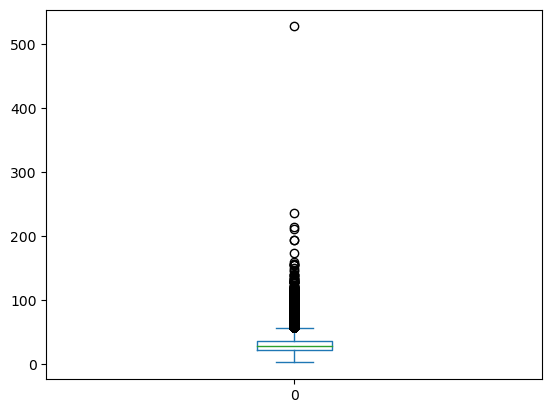

In [12]:
lengths.plot(kind='box')

In [13]:
# Remove the sentence with length 527 from the list
english_sentences.pop(lengths[lengths[0] == 527].index[0])
telugu_sentences.pop(lengths[lengths[0] == 527].index[0])

'ఏ పురుషుడైనా వివాహం చేసుకోవడానికి మరియు దీనికి విరుద్ధంగా సరైన స్త్రీ ఈ ప్రపంచంలో ఖచ్చితంగా ఉన్నారనడంలో సందేహం లేదు'

In [14]:
# Create vocabularies for Telugu and English words
telugu_vocab = get_vocab(telugu_sentences)
english_vocab = get_vocab(english_sentences)

# Add special tokens to the vocabularies
telugu_vocab  = ['<pad>','<unk>','<sos>','<eos>'] + telugu_vocab
english_vocab = ['<pad>','<unk>','<sos>','<eos>'] + english_vocab

print(f' len(english_vocab): {len(english_vocab)}')
print(f' len(telugu_vocab): {len(telugu_vocab)}')

 len(english_vocab): 14225
 len(telugu_vocab): 38835


In [15]:
# Create mappings between words and indices for both languages
english_itow = {i: w for i, w in enumerate(english_vocab)}
english_wtoi = {w:i for i, w in english_itow.items()}
 
telugu_itow = {i: w for i, w in enumerate(telugu_vocab)}
telugu_wtoi = {w:i for i, w in telugu_itow.items()}

print("english_itow = ", len(english_itow)) 
print("telugu_itow = ", len(telugu_itow))
print("english_wtoi = ", len(english_wtoi))
print("telugu_wtoi = ", len(telugu_wtoi))


english_itow =  14225
telugu_itow =  38835
english_wtoi =  14225
telugu_wtoi =  38835


In [16]:
# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(english_sentences, telugu_sentences, test_size=0.1)
len(X_train), len(Y_train), len(X_val), len(Y_val)

(140217, 140217, 15580, 15580)

In [17]:
# Tokenize the input and output of train data
X_train = tokenize_input(X_train, english_wtoi)
Y_train, Y_train_shifted = tokenize_output(Y_train, telugu_wtoi)
print(len(X_train), len(Y_train), len(Y_train_shifted))

140217 140217 140217


In [18]:
# Tokenize the input and output of val data
X_val = tokenize_input(X_val, english_wtoi)
Y_val, Y_val_shifted = tokenize_output(Y_val, telugu_wtoi)
print(len(X_val), len(Y_val), len(Y_val_shifted))

15580 15580 15580


In [19]:
# Assign buckets based on sentence lengths
train_buckets = assign_buckets(X_train, [8, 16, 32, 64], [256, 128, 64, 8])
val_buckets = assign_buckets(X_val, [8, 16, 32, 64], [256, 128, 64, 8])

In [20]:
# Group together
train_items = (X_train, Y_train, Y_train_shifted, train_buckets)
val_items = (X_val, Y_val, Y_val_shifted, val_buckets)

In [21]:
def data_generator(data_items, shuffle = True, verbose = False):
    
    X, Y, Y_shifted, buckets = data_items
    
    bin = r.choices(list(buckets.keys()), weights= [0.25, 0.25, 0, 0])[0]   # made probs of sequence length more than 16 to be 0 because of less data prone to overfitting.
        
    indexes = buckets[bin]
    batch_size = bin[2]
    
    if shuffle:
        r.shuffle(indexes)
    
    buffer_x = [0]*batch_size
    buffer_y = [0]*batch_size
    buffer_y_shifted = [0]*batch_size
    
    max_length_x = bin[1]
    max_length_y = 0
    
    for i in range(batch_size):
        buffer_x[i] = X[indexes[i]]
        buffer_y[i] = Y[indexes[i]]
        buffer_y_shifted[i] = Y_shifted[indexes[i]]
        max_length_y = max(len(Y[indexes[i]]), max_length_y)
    
    max_length_y = 2**int(np.ceil((np.log2(max_length_y))))

    
    for index, (x, y, y_shifted) in enumerate(zip(buffer_x, buffer_y, buffer_y_shifted)):
        pad_length_x = max_length_x - len(x)
        pad_length_y = max_length_y - len(y)
        
        buffer_x[index] = x + [english_wtoi['<pad>']] * pad_length_x
        buffer_y[index] = y + [telugu_wtoi['<pad>']] * pad_length_y
        buffer_y_shifted[index] = y_shifted + [telugu_wtoi['<pad>']] * pad_length_y
    
    
    buffer_x = torch.tensor(buffer_x)
    buffer_y = torch.tensor(buffer_y)
    buffer_y_shifted = torch.tensor(buffer_y_shifted)
    
    if verbose == True:
        print(buffer_x.shape, buffer_y.shape, buffer_y_shifted.shape)
    
    return buffer_x, buffer_y, buffer_y_shifted

In [22]:
train_input, train_target, train_target_shifted = data_generator(train_items,shuffle = True, verbose= True)

torch.Size([256, 8]) torch.Size([256, 8]) torch.Size([256, 8])


In [23]:
val_input, val_target, val_target_shifted = data_generator(val_items ,shuffle = True, verbose= True)

torch.Size([128, 16]) torch.Size([128, 16]) torch.Size([128, 16])


In [24]:
class Encoder(nn.Module):
    def __init__(self, input_vocab_size, embedding_dim, hidden_dim):        
        super().__init__()
        self.embedding = nn.Embedding(input_vocab_size, embedding_dim)
        self.LSTM = nn.LSTM(embedding_dim, hidden_size= hidden_dim,num_layers=2, batch_first=True)
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.LSTM(x)[0]
        return x

# Just for testing
test_encoder = Encoder(len(english_wtoi), embedding_dim=10, hidden_dim=1)
encoder_output = test_encoder.forward(train_input)# (batch_size, input_sequence_length, hidden_dim)
encoder_output.shape

torch.Size([256, 8, 1])

In [25]:
class PreAttentionDecoder(nn.Module):
    def __init__(self, target_vocab_size, embedding_dim, hidden_dim):
        super(PreAttentionDecoder, self).__init__()
        self.embedding = nn.Embedding(target_vocab_size, embedding_dim)
        self.LSTM = nn.LSTM(embedding_dim, hidden_dim, num_layers = 2, batch_first=True)
        
    def forward(self, y):
        y = self.embedding(y)
        y = self.LSTM(y)[0]
        return y

# For testing
test_decoder = PreAttentionDecoder(len(telugu_wtoi), embedding_dim = 10, hidden_dim =1)
decoder_output = test_decoder.forward(val_target_shifted) # (batch_size, target_shifted_length, hidden_dim)
decoder_output.shape

torch.Size([128, 16, 1])

In [26]:
def prepare_attention_input(encoder_output, decoder_output, input):

    keys = encoder_output
    values = encoder_output
    
    queries = decoder_output
    
    mask = (input == 0)
    mask = mask.unsqueeze(-2)
    mask = mask.repeat(4, decoder_output.shape[1], 1)
    
    #mask = mask.view((mask.shape[0] * 1, 1, mask.shape[1]))  
    #mask = mask + torch.zeros((1, decoder_output.shape[1], 1))

    # mask shape = (batch_size * num_heads_attention, target_shifted_length, input_sequence_length) 
    
    return queries, keys, values, mask

In [27]:
class Translator(nn.Module):
    def __init__(self, input_vocab_size, embedding_dim, hidden_dim, target_vocab_size):
        super(Translator, self).__init__()
        self.encoder = Encoder(input_vocab_size, embedding_dim, hidden_dim)
        self.predecoder = PreAttentionDecoder(target_vocab_size, embedding_dim, hidden_dim) 
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads = 4, batch_first = True)
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, num_layers = 2, batch_first = True)
        self.linear = nn.Linear(hidden_dim, target_vocab_size)
        
    def forward(self, input, target_shifted):
        q, k, v, m = prepare_attention_input(self.encoder(input), self.predecoder(target_shifted), input)
        attn_output, _ = self.attention(q, k, v, attn_mask = m)
        attn_output = attn_output + q
        attn_output = nn.LayerNorm([attn_output.shape[1], attn_output.shape[2]])(attn_output)
        y = self.decoder(attn_output)[0]
        logits = self.linear(y)
        return logits
        

In [28]:
def model_train(train_items, val_items, epochs, NNmodel):
    interval = epochs // 10
    optimizer = optim.AdamW(NNmodel.parameters())
    NNmodel.train()
    
    for epoch in range(1, epochs + 1):
        input, target, target_shifted = data_generator(train_items)
        logits = NNmodel.forward(input, target_shifted)
        logits = logits.view(-1, len(telugu_wtoi))
        target = target.view(-1)
        loss = F.cross_entropy(logits, target, ignore_index=telugu_wtoi['<pad>'])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % interval == 0:
            val_input, val_target, val_target_shifted = data_generator(val_items)
            val_logits = NNmodel.forward(val_input, val_target_shifted)
            val_logits = val_logits.view(-1, len(telugu_wtoi))
            val_target = val_target.view(-1)
            val_loss = F.cross_entropy(val_logits, val_target, ignore_index=telugu_wtoi['<pad>'])
            print(f'Loss at epoch {epoch} ====> train: {loss.item():.4f}, val: {val_loss.item():.4f}')
        
    
    return loss, logits

In [29]:
@torch.no_grad()
def evaluate(NNmodel):
    input, target, target_shifted = data_generator(val_items)
    logits = NNmodel.forward(input, target_shifted)

    preds = F.softmax(logits, dim = 2)
    preds = torch.argmax(preds, dim = 2)

    mask = target != telugu_wtoi['<pad>']
    accuracy = torch.sum(preds == target)/float(torch.sum(mask)) *100

    logits = logits.view(-1, len(telugu_wtoi))
    target = target.view(-1)

    loss = F.cross_entropy(logits, target, ignore_index = telugu_wtoi['<pad>'])

    print(f'Loss = {loss:.2f}, Accuracy = {accuracy:.2f}')
    return None


In [30]:
def logsoftmax_sample(log_probs, temperature=1.0, dim = 0): 
  """Returns a sample from a log-softmax output, with temperature.

  Args:
    log_probs: Logarithms of probabilities (often coming from LogSofmax)
    temperature: For scaling before sampling (1.0 = default, 0.0 = pick argmax)
  """
  # This is equivalent to sampling from a softmax with temperature.
  u = np.random.uniform(low=1e-6, high=1.0 - 1e-6, size=log_probs.shape)
  g = torch.tensor(-np.log(-np.log(u)))
  return torch.argmax(log_probs + g * temperature, dim = dim)

In [31]:
@torch.no_grad()
def next_symbol(NNmodel, input_token, cur_output_tokens):
    
    token_length = len(cur_output_tokens)
    padded_length = 2**int(np.ceil((np.log2(token_length))))
    padded = torch.tensor(cur_output_tokens + [0]*(padded_length - token_length))
    padded = padded.view(1, padded_length)
    
    logits = NNmodel(input_token, padded)
    
    prob_last_token = F.softmax(logits, dim = 2)[0, token_length - 1]
    symbol_index = int(torch.argmax(prob_last_token, dim =0))
    
    return symbol_index, float(prob_last_token[symbol_index])



def sampling_decode(NNmodel, input_sentence, input_wtoi, output_itow, output_wtoi):
    
    input_token = torch.tensor(tokenize_input(input_sentence, input_wtoi))
    
    cur_output_tokens = [output_wtoi['<sos>']]
    cur_output = 0
    
    EOS = output_wtoi['<eos>']
    while cur_output != EOS:
        cur_output, log_prob = next_symbol(NNmodel, input_token, cur_output_tokens)
        cur_output_tokens.append(cur_output)
    sentence = detokenize(cur_output_tokens,output_itow)
    
    return cur_output_tokens, sentence, log_prob

In [97]:
input_vocab_size = len(english_wtoi)
embedding_dim = 256
hidden_dim = 512
target_vocab_size = len(telugu_wtoi)
model = Translator(input_vocab_size, embedding_dim, hidden_dim, target_vocab_size)

n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
n_parameters

46115251

In [106]:
loss, logits = model_train(train_items, val_items, 20, model)

Loss at epoch 2 ====> train: 6.9497, val: 6.4495
Loss at epoch 4 ====> train: 6.7768, val: 7.1361
Loss at epoch 6 ====> train: 6.6992, val: 6.4101
Loss at epoch 8 ====> train: 6.2812, val: 6.8773
Loss at epoch 10 ====> train: 6.1302, val: 6.0598
Loss at epoch 12 ====> train: 7.2110, val: 6.7701
Loss at epoch 14 ====> train: 6.1419, val: 6.6662
Loss at epoch 16 ====> train: 6.8013, val: 6.2881
Loss at epoch 18 ====> train: 6.7256, val: 6.6590
Loss at epoch 20 ====> train: 6.1398, val: 6.7583


In [110]:
input_sentence = preprocess(["I love you"]) 
sampling_decode(model, input_sentence,input_wtoi= english_wtoi, output_itow=telugu_itow, output_wtoi=telugu_wtoi)


([2, 31395, 22796, 3], '<sos> టామ్ చాలా <eos>', 0.025383463129401207)